In [1]:
# Check tensorflow version
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None,):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend
    plt.grid(True)

In [3]:
import csv
time_step = []
temps = []
step = 0
with open('/ITX.MC.csv') as csvfile:
    reader = csv.reader(csvfile,delimiter =',')
    next(reader)
    for row in reader:
        time_step.append(step)
        temps.append(float(row[4]))
        step += 1
        
series = np.array(temps)
time = np.array(time_step)

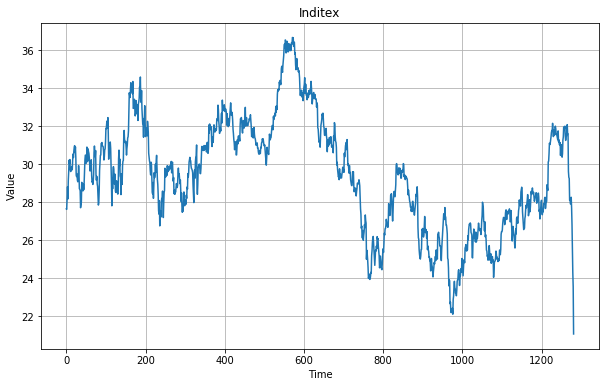

In [4]:
plt.figure(figsize=(10, 6))
plt.title("Inditex")
plot_series(time, series)

In [5]:
print(len(time_step))

1282


In [6]:
# Split train and valid data
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 20
shuffle_buffer_size = 1000



In [7]:
# Structure each record with a sequence of historical data the size of the time window.
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## LSTM BI

In [8]:
# Design and train the neural network
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(160, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),  
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# For found the best learning rate
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
#history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
history = model.fit(dataset, epochs=100)

Epoch 1/100
54/54 [==============================] - 10s 194ms/step - loss: 7.9721 - mae: 8.4303
Epoch 2/100
54/54 [==============================] - 4s 66ms/step - loss: 0.5326 - mae: 0.9216
Epoch 3/100
54/54 [==============================] - 3s 55ms/step - loss: 0.3653 - mae: 0.7331
Epoch 4/100
54/54 [==============================] - 3s 50ms/step - loss: 0.3264 - mae: 0.6813
Epoch 5/100
54/54 [==============================] - 3s 50ms/step - loss: 0.3272 - mae: 0.6830
Epoch 6/100
54/54 [==============================] - 3s 53ms/step - loss: 0.2663 - mae: 0.6018
Epoch 7/100
54/54 [==============================] - 2s 45ms/step - loss: 0.2880 - mae: 0.6320
Epoch 8/100
54/54 [==============================] - 2s 44ms/step - loss: 0.2339 - mae: 0.5550
Epoch 9/100
54/54 [==============================] - 2s 45ms/step - loss: 0.2253 - mae: 0.5455
Epoch 10/100
54/54 [==============================] - 2s 46ms/step - loss: 0.2133 - mae: 0.5276
Epoch 11/100
54/54 [===========================

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 320)         207360    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                43136     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 250,529
Trainable params: 250,529
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Graph loss in function of learning rate, to select the best learning rate.
#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-3, 0, 30])

<Figure size 432x288 with 0 Axes>

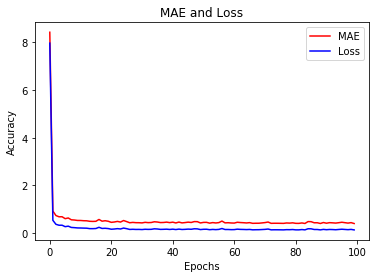

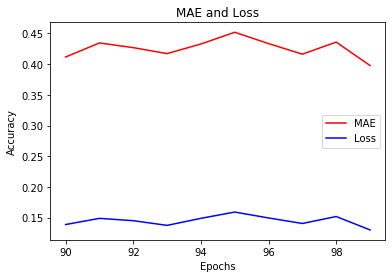

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[90:]
mae_zoom = mae[90:]
loss_zoom = loss[90:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [12]:
# Save model
model.save('inditex_lstm_bi_160_16_dense_1.h5')


In [13]:
# Load model
#model = keras.models.load_model('inditex.h5')

In [14]:
# Prediction of all data
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Prediction for validation data
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

0.39374948

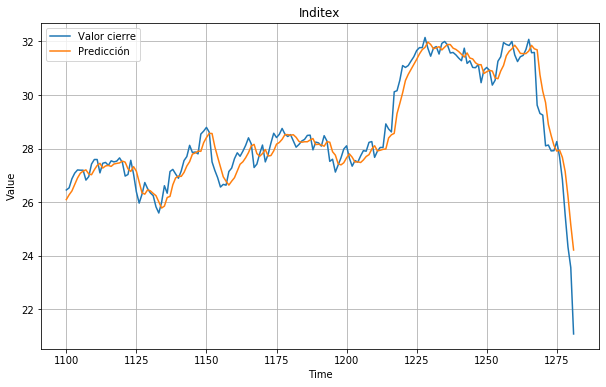

In [16]:
# Graph real data and validation data.

plt.figure(figsize=(10, 6))
plt.title('Inditex')
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.legend(['Valor cierre','Predicción'])

In [17]:
# Predict the next five days after validation data
series1 = series[1262:]
results1 = results
for i in range(5):
    #print(i)
    pre = model.predict(series1[i:][np.newaxis])
    print("Day {} = {}".format(i+1,pre[0]))
    print("")
    series1 = np.concatenate((series1,pre[0]))
    #print(series1)
    results1 = np.concatenate((results1,pre[0]))
    

Day 1 = [22.509155]

Day 2 = [22.333782]

Day 3 = [22.131147]

Day 4 = [21.98544]

Day 5 = [21.893032]



In [18]:
# Time series for the next five days
time_results1 = np.concatenate((time_valid, np.arange(1282,1287,1)),axis=None)


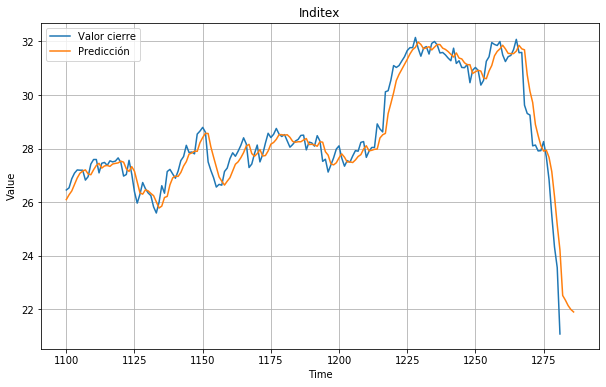

In [20]:
# Graph real data, validation data and the following five days.
plt.figure(figsize=(10, 6))
plt.title('Inditex')
plot_series(time_valid, x_valid)
plot_series(time_results1, results1)
plt.legend(['Valor cierre','Predicción'])